## Recommender System Implementation 
>Paper title: Qusai Shambour, "A deep learning based algorithm for multi-criteria recommender systems", Knowledge-Based System 2021
1. Model name: AEMC 
2. Domain: Multi-Criteria Recommender System (MCRS)
2. Code writer: Jin-Duk Park (github: https://github.com/jindeok, homepage: https://jindeok.github.io/jdpark/)

In [87]:
import random
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

random.seed(2022)
np.random.seed(2022)


In [114]:
# 1. Load Rating matrix
# TripAdvisor with 5-core setting is used, in this case.
# TripAdvisor dataset have 7 criteria, and a single overall rating

# Load and Configurations
raw_train = pd.read_csv('TA5/train.csv') 
unique_user = raw_train.UserID.unique()
unique_item = raw_train.ItemID.unique()
n_user = len(unique_user)
n_item = len(unique_item)
n_cri = 7 # number of multi-criteria

mcr_ratings_tr = [raw_train.iloc[:,cri].values for cri in range(3,n_cri+3)]
overall_tr = raw_train.iloc[:,2].values

In [115]:
# Training matrix 
R_tr = torch.zeros((n_cri, n_user, n_item)) # (C X U X I) 3-rank tensor
OR_tr = torch.zeros((n_user, n_item))

for idx, edge in enumerate(raw_train[['UserID','ItemID']].values):
    OR_tr[edge[0]][edge[1]] = overall_tr[idx]
    for cri in range(n_cri):
        R_tr[cri][edge[0]][edge[1]] = mcr_ratings_tr[cri][idx]


In [203]:
# Test matrix 
raw_test = pd.read_csv('ex_TA5/test.csv')   
mcr_ratings_ts = [raw_test.iloc[:,cri].values for cri in range(3,n_cri+3)]
overall_ts = raw_test.iloc[:,2].values
OR_ts = torch.zeros((n_user, n_item))
R_ts = torch.zeros((n_cri, n_user, n_item)) # (C X U X I) 3-rank tensor
for idx, edge in enumerate(raw_test[['UserID','ItemID']].values):
    OR_ts[edge[0]][edge[1]] = overall_ts[idx]
    for cri in range(n_cri):
        R_ts[cri][edge[0]][edge[1]] = mcr_ratings_ts[cri][idx]

In [118]:
# 2. Concat every rating matrix horizontally ** for training **

# concat criteria -> (U X I) tensor with C * U dimensional vectors
for i, r_c in enumerate(R_tr):
    if i == 0:
        r_train = r_c
    else:
        r_train = torch.cat((r_train, r_c), dim=1)

# concat criteria -> (U X I) tensor with C * U dimensional vectors
for i, r_c in enumerate(R_ts):
    if i == 0:
        r_test = r_c
    else:
        r_test = torch.cat((r_test, r_c), dim=1)

In [282]:
# 3. Splice each row (user ratings) as instances. (with torch Datalodaer)
# Here, validation data is not used following original implementation of the paper
train_ds = TensorDataset(r_train, OR_tr)
train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)

In [281]:
# Model with 7 Criteria (TripAdvisor)
class AEMC(nn.Module):
    def __init__(self, n_item, n_cri):
        '''
        If you want C number of criteria,
        use self.netk with k upto ~C 
        '''
        super().__init__()
        
        self.n_cri = n_cri
        self.n_item = n_item
        self.net1 = nn.Sequential(
            nn.Linear(self.n_item, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, self.n_item) )
        self.net2 = nn.Sequential(
            nn.Linear(self.n_item, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, self.n_item) )
        self.net3 = nn.Sequential(
            nn.Linear(self.n_item, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, self.n_item) )
        self.net4 = nn.Sequential(
            nn.Linear(self.n_item, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, self.n_item) )
        self.net5 = nn.Sequential(
            nn.Linear(self.n_item, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, self.n_item) )
        self.net6 = nn.Sequential(
            nn.Linear(self.n_item, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, self.n_item) )
        self.net7 = nn.Sequential(
            nn.Linear(self.n_item, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, self.n_item) )

        

    def forward(self, x):
        '''
        returns overall rating vector for an user
        '''
        cri_x = []
        cri_x.append(self.net1(x[:,self.n_item * 0: self.n_item * (0 + 1)]))
        cri_x.append(self.net2(x[:,self.n_item * 1: self.n_item * (1 + 1)]))
        cri_x.append(self.net3(x[:,self.n_item * 2: self.n_item * (2 + 1)]))
        cri_x.append(self.net4(x[:,self.n_item * 3: self.n_item * (3 + 1)]))
        cri_x.append(self.net5(x[:,self.n_item * 4: self.n_item * (4+ 1)]))
        cri_x.append(self.net6(x[:,self.n_item * 5: self.n_item * (5+ 1)]))
        cri_x.append(self.net7(x[:,self.n_item * 6: self.n_item * (6+ 1)]))

        # aggregate multi-criteria information
        overall_x = sum(cri_x) / self.n_cri 
        
        return overall_x

epochs:0, batch_loss:0.0472
epochs:1, batch_loss:0.0391
epochs:2, batch_loss:0.0355
epochs:3, batch_loss:0.0336
epochs:4, batch_loss:0.0240
epochs:5, batch_loss:0.0194
epochs:6, batch_loss:0.0159
epochs:7, batch_loss:0.0142
epochs:8, batch_loss:0.0129
epochs:9, batch_loss:0.0117
epochs:10, batch_loss:0.0105
epochs:11, batch_loss:0.0097
epochs:12, batch_loss:0.0085
epochs:13, batch_loss:0.0072
epochs:14, batch_loss:0.0073
epochs:15, batch_loss:0.0075
epochs:16, batch_loss:0.0053
epochs:17, batch_loss:0.0055
epochs:18, batch_loss:0.0045
epochs:19, batch_loss:0.0048
epochs:20, batch_loss:0.0046
epochs:21, batch_loss:0.0039
epochs:22, batch_loss:0.0044
epochs:23, batch_loss:0.0041
epochs:24, batch_loss:0.0034
epochs:25, batch_loss:0.0034
epochs:26, batch_loss:0.0029
epochs:27, batch_loss:0.0028
epochs:28, batch_loss:0.0031
epochs:29, batch_loss:0.0027


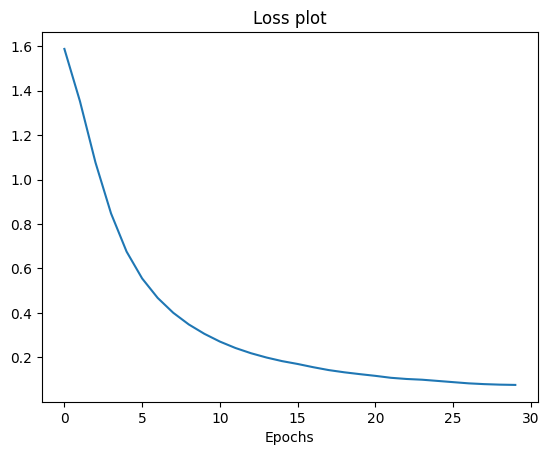

In [284]:
# 4. Training

model = AEMC(n_item, n_cri)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 30

losses = []
for ep in range(epochs):
    batch_loss = 0
    for (x,y) in train_dataloader:
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(y, pred)
        loss.backward()
        optimizer.step()
        batch_loss += loss.item()       
    print(f"epochs:{ep}, batch_loss:{loss.item():.4f}") 
    losses.append(batch_loss)

# Plot loss
from matplotlib import pyplot as plt
plt.title('Loss plot')
plt.xlabel('Epochs')
plt.plot(losses)
plt.show()

In [276]:
# Evaluation functions

def top_k(S, k=1):
    """
    S: scores, numpy array of shape (M, N) where M is the number of source nodes,
        N is the number of target nodes
    k: number of predicted elements to return
    """
    top = np.argsort(-S)[:, :k]
    result = np.zeros(S.shape)
    for idx, target_elms in enumerate(top):
        for elm in target_elms:
            result[idx, elm] = 1

    return result, top
    
def precision_k(topk, gt, k):
    '''
    topk, gt: (UXI) array
    k: @k measurement
    '''
    return np.multiply(topk, gt).sum() / (k * len(gt))


def recall_k(topk, gt, k):
    '''
    topk, gt: (UXI) array
    k: @k measurement
    '''
    return np.multiply(topk, gt).sum() / gt.sum()

def ndcg_k(rels, rels_ideal, gt, k):
    '''
    rels: sorted top-k arr
    rels_ideal: sorted top-k ideal arr
    k: @k measurement
    '''
    dcg =0; idcg = 0
    for row, (row_rels, row_rels_i) in enumerate(zip(rels, rels_ideal)):
        for rel, rel_i in zip(row_rels, row_rels_i):
            if gt[row][rel] == 1:
                if i==0:
                    dcg += 1
                else:
                    dcg += 1/np.log2(i+1)
            if gt[row][rel_i] == 1:
                if i==0:
                    idcg += 1
                else:
                    idcg += 1/np.log2(i+1)
    return dcg/idcg

In [285]:
# Start evaluation procedure for multi-criteria recommender system.
import copy

# Prediction, 
# Put every test set at once ( * if memory issue exists, slice it with batch instances * )
model.eval()
test_pred = model(r_train)
results = test_pred.detach().numpy()

# (UXI) topk_pr_mat, gt_mat
top_10_mat, rel10 = top_k(results, k = 10)
top_5_mat, rel5 = top_k(results, k = 5)

# Processing gt
gt_mat = copy.deepcopy(OR_ts.detach().numpy())
gt_mat[gt_mat<3] = 0
gt_mat[gt_mat>=3] = 1
_, i_rel10 =top_k(gt_mat, k = 10)
_, i_rel5 =top_k(gt_mat, k = 5)

# measure ranking-based evaluations
print(f"PR@5: {precision_k(top_5_mat, gt_mat, 5):.4f}, PR@10: {precision_k(top_10_mat, gt_mat, 10):.4f} \n")
print(f"RE@5: {recall_k(top_5_mat, gt_mat, 5):.4f}, RE@10: {recall_k(top_10_mat, gt_mat, 10):.4f} \n")
print(f"NDCG@5: {ndcg_k(rel5, i_rel5, gt_mat, k = 5):.4f} NDCG@10: {ndcg_k(rel10, i_rel10, gt_mat, k = 10):.4f} \n")

PR@5: 0.0052, PR@10: 0.0096 

RE@5: 0.0172, RE@10: 0.0636 

NDCG@5: 0.0176 NDCG@10: 0.0636 

